# VAR models via tensor decompostion

### Antoine LE MAGUET, Alexandre MALLEZ


In [32]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from Data_generation import generate_stationary_mlr_data, generate_sparse_data_simulation
from MLR import alternating_least_square
from SHORR import alternating_direction_method_of_multipliers,lambda_optimal
from Base_estimators import lasso_regression, nuclear_norm_estimator, reduced_rank_regression, ordinary_least_square
from Asymptotic_Variance import calculate_asymptotic_variance_MLR, calculate_covariances_OLS_RRR
from Rank_selection import select_ranks
from tqdm import tqdm

---

## Asymptotic variance convergence :

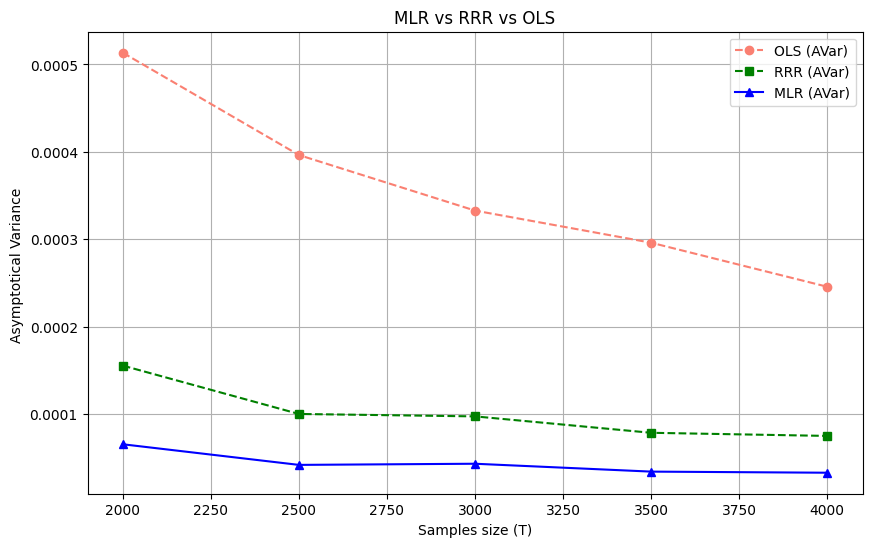

In [336]:
N = 10          # Variables
P = 5           # Lags
T_values = [2000, 2500, 3000, 3500, 4000] # T
ranks = [3, 3, 3]

results_avar_ols = []
results_avar_rrr = []
results_avar_mlr = []


for T in T_values:

    # Data
    y_sim, A_true = generate_stationary_mlr_data(N, P, T, ranks, target_rho=0.8)
    T_eff = y_sim.shape[1] - P

    A_init = A_true + np.random.randn(*A_true.shape) * 0.1
    A_mlr, G_est, U1_est, U2_est, U3_est = alternating_least_square(A_init, ranks, y_sim, T_eff, P)

    # Variance asymptotique MLR
    _, avar_mlr = calculate_asymptotic_variance_MLR(y_sim, A_mlr, G_est, U1_est, U2_est, U3_est, T_eff, P)

    # OLS et RRR
    _, avar_ols, _, avar_rrr = calculate_covariances_OLS_RRR(y_sim, A_mlr, T_eff, P, ranks[0])

    results_avar_ols.append(avar_ols/T)
    results_avar_rrr.append(avar_rrr/T)
    results_avar_mlr.append(avar_mlr/T)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(T_values, results_avar_ols, 'o--', label='OLS (AVar)', color='salmon')
plt.plot(T_values, results_avar_rrr, 's--', label='RRR (AVar)', color='green')
plt.plot(T_values, results_avar_mlr, '^-', label='MLR (AVar)', color='blue')

plt.xlabel('Samples size (T)')
plt.ylabel('Asymptotical Variance ')
plt.title('MLR vs RRR vs OLS')
plt.legend()
plt.grid(True)
plt.show()

The asymptotic variance decays as predicted, the MLR estimator have better (lower) variance, moreover it converges to 0 then it is consistent

---

# Using self-generated data : 

## Performance comparaison

Starting Comparison Simulation (N=5, P=2, Ranks=[2, 2, 2])...
  Simulating T = 100...
  Simulating T = 200...
  Simulating T = 400...
  Simulating T = 600...
  Simulating T = 800...


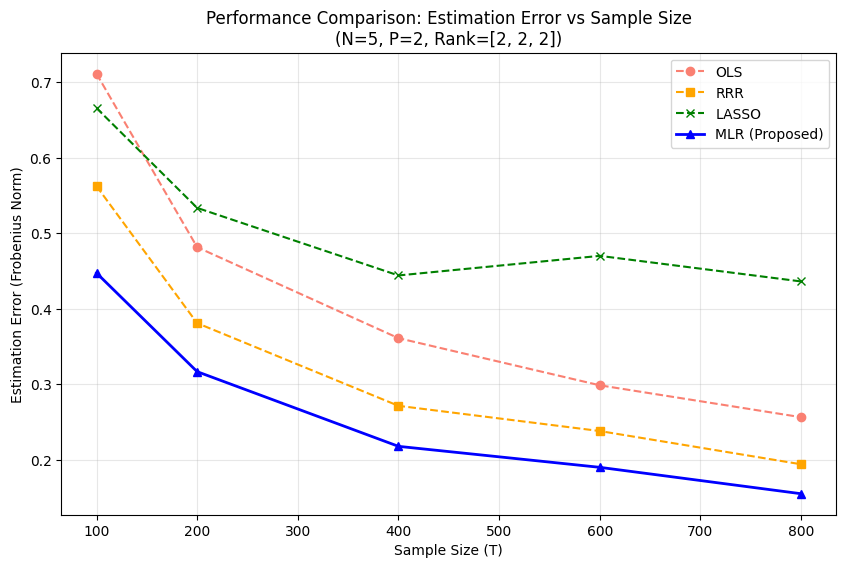

In [11]:
N = 5
P = 2
ranks = [2, 2, 2]
T_values = [100, 200, 400, 600, 800] # Varying sample sizes
n_simulations = 10 # samples

# Storage for results
errors_OLS = []
errors_RRR = []
errors_MLR = []
errors_LASSO = []

print(f"Starting Comparison Simulation (N={N}, P={P}, Ranks={ranks})...")

for T in T_values:
    print(f"  Simulating T = {T}...")

    err_ols_list = []
    err_rrr_list = []
    err_mlr_list = []
    err_lasso_list = []

    for sim in range(n_simulations):
        # Generate Data
        y_sim, A_true = generate_stationary_mlr_data(N, P, T, ranks, target_rho=0.7, noise_std=1.0)
        T_eff = y_sim.shape[1] - P

        # MLR
        A_init = A_true + np.random.randn(*A_true.shape) * 0.1
        A_mlr = alternating_least_square(A_init, ranks, y_sim, T_eff, P, max_iter=20)[0] #20 for speed

        # OLS
        A_ols = ordinary_least_square(y_sim, T_eff, P)

        # RRR
        A_rrr = reduced_rank_regression(y_sim, T_eff, P, ranks[0])

        # Lasso
        A_lasso = lasso_regression(y_sim, T_eff, P, alpha=0.05)

        # errors
        err_mlr_list.append(normF(A_mlr - A_true))
        err_ols_list.append(normF(A_ols - A_true))
        err_rrr_list.append(normF(A_rrr - A_true))
        err_lasso_list.append(normF(A_lasso - A_true))

    # Average errors for this T
    errors_OLS.append(np.mean(err_ols_list))
    errors_RRR.append(np.mean(err_rrr_list))
    errors_MLR.append(np.mean(err_mlr_list))
    errors_LASSO.append(np.mean(err_lasso_list))

# Plot
plt.figure(figsize=(10, 6))

plt.plot(T_values, errors_OLS, 'o--', label='OLS', color='salmon')
plt.plot(T_values, errors_RRR, 's--', label='RRR', color='orange')
plt.plot(T_values, errors_LASSO, 'x--', label='LASSO', color='green')
plt.plot(T_values, errors_MLR, '^-', label='MLR (Proposed)', color='blue', linewidth=2)

plt.xlabel('Sample Size (T)')
plt.ylabel('Estimation Error (Frobenius Norm)')
plt.title(f'Performance Comparison: Estimation Error vs Sample Size\n(N={N}, P={P}, Rank={ranks})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

It confirms that MLR estimator is better than other methods to predict a generated signal.

### Bias and Variance vs sample size

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


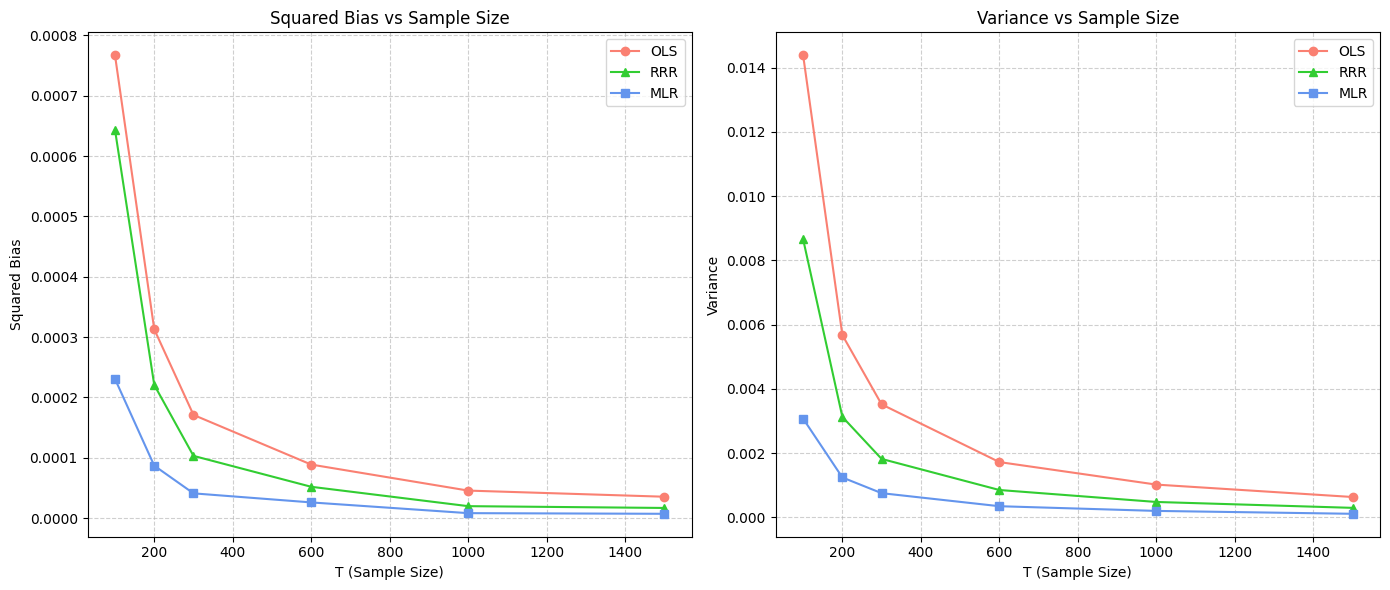

In [3]:
N = 8     # Variables
P = 4     # Lags
T = 300   # Temps de simulation
ranks = [3, 3, 2] # Rangs multilinaire

_ , A_true = generate_stationary_mlr_data(N, P, 1, ranks, target_rho=0.90, noise_std=0.1)
noise_std = 0.1
n_estimates = 20  # Number of simulation
list_T = [100, 200, 300, 600, 1000, 1500]# samples size

#bias
BiasSq_MLR, BiasSq_OLS, BiasSq_RRR = [], [], []

#Variance
Var_MLR, Var_OLS, Var_RRR = [], [], []


for T in list_T:


    est_MLR = []
    est_OLS = []
    est_RRR = []

    for i in tqdm(range(n_estimates)):
        # data
        y_sim = np.zeros((N, T + P + 100))
        epsilon = np.random.randn(N, T + P + 100) * noise_std
        A_mat = tensor_mode(A_true, 1) # [A1...AP]

        for t in range(P, T + P + 100):
            lagged_values = y_sim[:, t-P:t][:, ::-1]
            x_t = vec(lagged_values)
            y_sim[:, t] = A_mat @ x_t + epsilon[:, t]

        y_sim = y_sim[:, 100:] # Burn-in
        T_eff = y_sim.shape[1] - P

        # MLR
        A_init = A_true + np.random.randn(*A_true.shape) * 0.2
        A_mlr, _, _, _, _ = alternating_least_square(A_init, ranks, y_sim, T_eff, P)
        est_MLR.append(A_mlr)

        # OLS
        A_ols = ordinary_least_square(y_sim, T_eff, P)
        est_OLS.append(A_ols)

        # RRR (Rang r1)
        A_rrr = reduced_rank_regression(y_sim, T_eff, P, ranks[0])
        est_RRR.append(A_rrr)

    # Squared bias
    mean_MLR = np.mean(est_MLR, axis=0)
    mean_OLS = np.mean(est_OLS, axis=0)
    mean_RRR = np.mean(est_RRR, axis=0)

    BiasSq_MLR.append(np.mean((mean_MLR - A_true)**2))
    BiasSq_OLS.append(np.mean((mean_OLS - A_true)**2))
    BiasSq_RRR.append(np.mean((mean_RRR - A_true)**2))

    # variance
    Var_MLR.append(np.mean(np.var(est_MLR, axis=0)))
    Var_OLS.append(np.mean(np.var(est_OLS, axis=0)))
    Var_RRR.append(np.mean(np.var(est_RRR, axis=0)))

#Vizualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Squared Bias
ax1.plot(list_T, BiasSq_OLS, marker='o', label='OLS', color='salmon', linestyle='-')
ax1.plot(list_T, BiasSq_RRR, marker='^', label='RRR', color='limegreen', linestyle='-')
ax1.plot(list_T, BiasSq_MLR, marker='s', label='MLR', color='cornflowerblue', linestyle='-')

ax1.set_xlabel('T (Sample Size)')
ax1.set_ylabel('Squared Bias')
ax1.set_title('Squared Bias vs Sample Size')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Variance
ax2.plot(list_T, Var_OLS, marker='o', label='OLS', color='salmon', linestyle='-')
ax2.plot(list_T, Var_RRR, marker='^', label='RRR', color='limegreen', linestyle='-')
ax2.plot(list_T, Var_MLR, marker='s', label='MLR', color='cornflowerblue', linestyle='-')

ax2.set_xlabel('T (Sample Size)')
ax2.set_ylabel('Variance')
ax2.set_title('Variance vs Sample Size')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Starting Comparison Simulation (N=15, P=5, Ranks=[5, 5, 2])...
  Simulating T = 100...


100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


  Simulating T = 200...


100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


  Simulating T = 400...


100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


  Simulating T = 600...


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


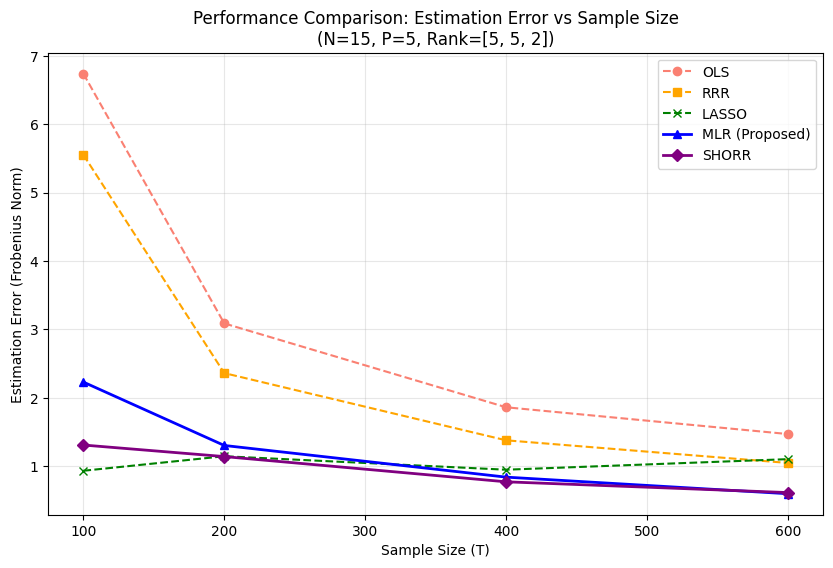

In [5]:
N = 15
P = 5
ranks = [5, 5, 2]
T_values = [100, 200, 400, 600]#, 800] # Varying sample sizes
n_simulations = 10 # samples

# Storage for results
errors_OLS = []
errors_RRR = []
errors_MLR = []
errors_LASSO = []
errors_SHORR = []

print(f"Starting Comparison Simulation (N={N}, P={P}, Ranks={ranks})...")

for T in T_values:
    print(f"  Simulating T = {T}...")

    err_ols_list = []
    err_rrr_list = []
    err_mlr_list = []
    err_lasso_list = []
    err_shorr_list = []

    for sim in range(n_simulations):
        # Generate Data
        sparsity = [4, 4, 2]    # s1, s2, s3
        y_sim, A_true, _, _ = generate_sparse_data_simulation(N, P, T, ranks, sparsity,target_rho=0.7, noise_std=0.1)
        T_eff = y_sim.shape[1] - P

        lamb = lambda_optimal(N, P, T, y_sim)
        # MLR
        A_init = nuclear_norm_estimator(y_sim, T_eff, P, lamb)
        A_mlr = alternating_least_square(A_init, ranks, y_sim, T_eff, P, max_iter=20)[0] #20 for speed

        # Lasso
        A_lasso = lasso_regression(y_sim, T_eff, P, alpha=0.05)

        #Shorr
        regul_params = [lamb/3,0.005,0.005,0.005]
        A_shorr = alternating_direction_method_of_multipliers(A_init, ranks, y_sim, T_eff, P,regul_params, max_iter=100)[0]
        
        # OLS
        A_ols = ordinary_least_square(y_sim, T_eff, P)

        # RRR
        A_rrr = reduced_rank_regression(y_sim, T_eff, P, ranks[0])

        # errors
        err_mlr_list.append(normF(A_mlr - A_true))
        err_shorr_list.append(normF(A_shorr - A_true))
        err_ols_list.append(normF(A_ols - A_true))
        err_rrr_list.append(normF(A_rrr - A_true))
        err_lasso_list.append(normF(A_lasso - A_true))

    # Average errors for this T
    errors_OLS.append(np.mean(err_ols_list))
    errors_SHORR.append(np.mean(err_shorr_list))
    errors_RRR.append(np.mean(err_rrr_list))
    errors_MLR.append(np.mean(err_mlr_list))
    errors_LASSO.append(np.mean(err_lasso_list))

# Plot
plt.figure(figsize=(10, 6))

plt.plot(T_values, errors_OLS, 'o--', label='OLS', color='salmon')
plt.plot(T_values, errors_RRR, 's--', label='RRR', color='orange')
plt.plot(T_values, errors_LASSO, 'x--', label='LASSO', color='green')
plt.plot(T_values, errors_MLR, '^-', label='MLR (Proposed)', color='blue', linewidth=2)
plt.plot(T_values, errors_SHORR, 'D-', label='SHORR', color='purple', linewidth=2)
plt.xlabel('Sample Size (T)')
plt.ylabel('Estimation Error (Frobenius Norm)')
plt.title(f'Performance Comparison: Estimation Error vs Sample Size\n(N={N}, P={P}, Rank={ranks})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Shorr is better on sparse data, however when the sample size grow larger, it seems to be even between SHORR and MLR, maybe because the regularization parametre are not adapted enough (need grid search which is need a lot of computationary power)

## Plot of the squared estimation error for SHORR Estimator

 Lancement Simulation Cas 'a' (N=10, P=5, S=18) <<<
    Rangs fixés : [2, 2, 2]


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


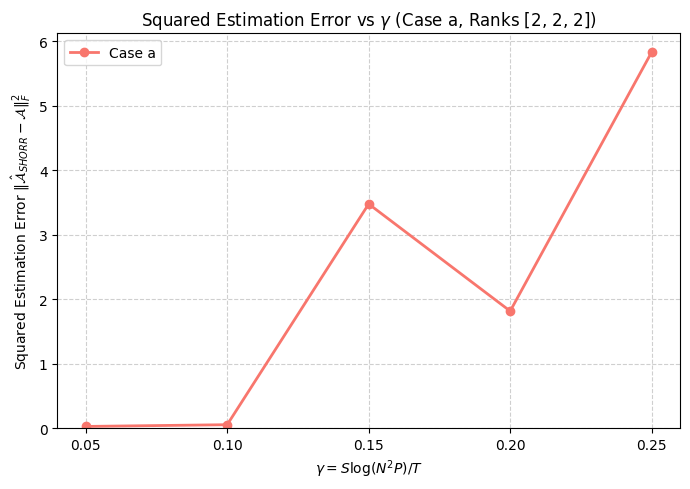

In [8]:

# Parametres
N, P = 10, 5
ranks = [2, 2, 2]       # r1, r2, r3
sparsity = [3, 3, 2]    # s1, s2, s3

# total sparsity S = s1*s2*s3
S_total = np.prod(sparsity) # 3*3*2 = 18

# Axe X : Gamma 
gamma_values = [0.05, 0.1, 0.15, 0.2, 0.25]

# repetition
n_reps = 2

avg_squared_errors = []

print(f" Lancement Simulation Cas 'a' (N={N}, P={P}, S={S_total}) <<<")
print(f"    Rangs fixés : {ranks}")

# Simulation loop
for gamma in gamma_values:

    #  T st gamma = S * log(N^2 * P) / T
    val_log = np.log(N**2 * P)
    T = int(np.ceil((S_total * val_log) / gamma))

    # Sécurité pour éviter T trop petit
    T = max(T, P + 20)

    errors_temp = []

    for _ in tqdm(range(n_reps)):
        try:
            # data generation
            Y, A_true, G, U = generate_sparse_data_simulation(N, P, T, ranks, sparsity, noise_std=0.1)

            # lambda value
            lam_val = 0.2 * np.sqrt(val_log / T)
            
            # [lambda, rho1, rho2, rho3]
            regul_params = [lam_val, 5.0, 5.0, 5.0]

            # initialization
            A_init = nuclear_norm_estimator(Y, T, P, lambda_val=0.001)

            #Estimation
            A_hat = alternating_direction_method_of_multipliers(
                A_0=A_init,
                ranks=ranks,
                y=Y,
                T_all=T,
                P=P,
                regularisators=regul_params,
                show=False,
                max_iter=80
            )[0]

            # Error
            err_sq = np.linalg.norm((A_hat - A_true).flatten())**2
            errors_temp.append(err_sq)

        except Exception as e:
            continue

    # mean error
    mean_err = np.mean(errors_temp) if errors_temp else 0
    avg_squared_errors.append(mean_err)


# Plot
plt.figure(figsize=(7, 5))

plt.plot(gamma_values, avg_squared_errors,
         marker='o', color='#F8766D', linewidth=2, label="Case a")

plt.title(f"Squared Estimation Error vs $\gamma$ (Case a, Ranks {ranks})")
plt.xlabel(r'$\gamma = S \log(N^2 P) / T$')
plt.ylabel(r'Squared Estimation Error $\|\hat{\mathcal{A}}_{SHORR} - \mathcal{A}\|_F^2$')

plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(gamma_values)
plt.legend()

plt.tight_layout()
plt.show()

It's not very precise (should be an affine function), sameway due to not very well-chosen regularizations parametre

---

# Real Data

# Macroenomy dataset in the US

4values/year for 51 years


In [ ]:
!pip install statsmodels

50.891049504950495 59.87212664543536


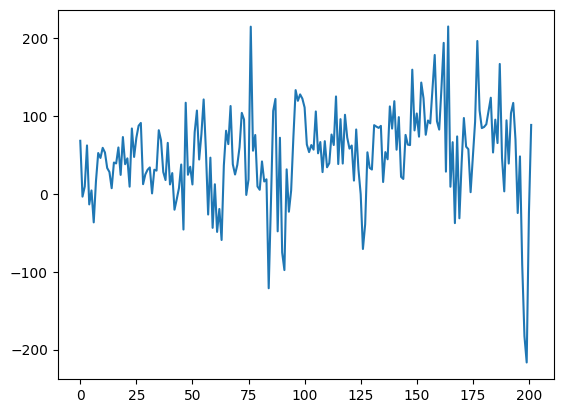

37.369306930693064 33.6626059320059


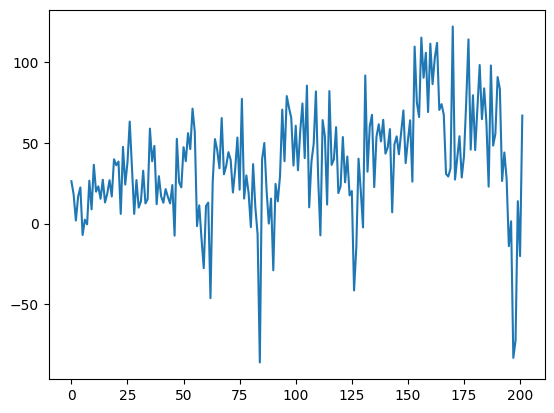

5.938118811881188 44.54167667705949


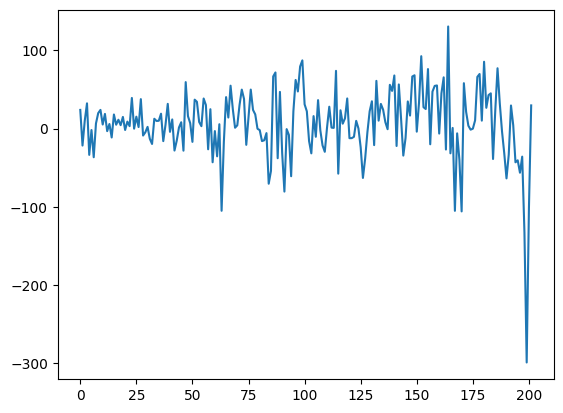

2.8417970297029695 12.894458366973579


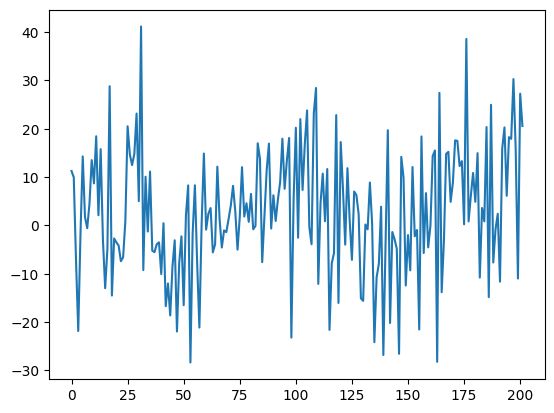

40.36485148514852 53.420981733157774


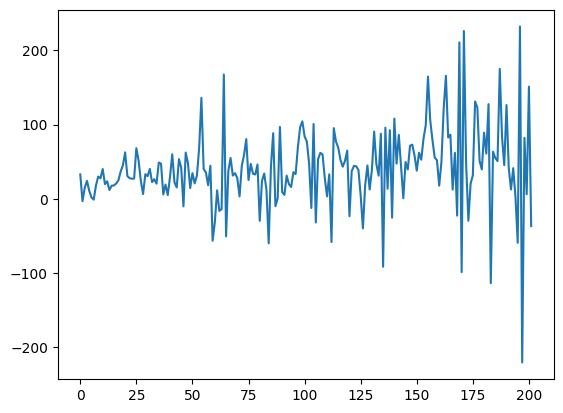

0.9277475247524751 0.8911750173247531


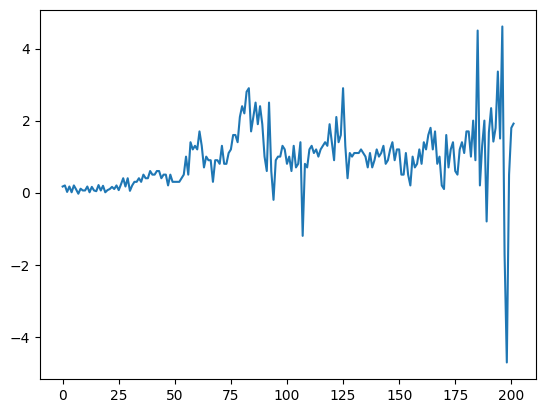

7.595049504950495 13.150803734332571


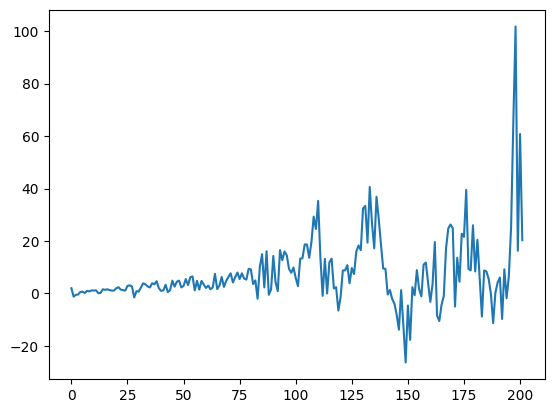

-0.013366336633663371 0.8695085413158591


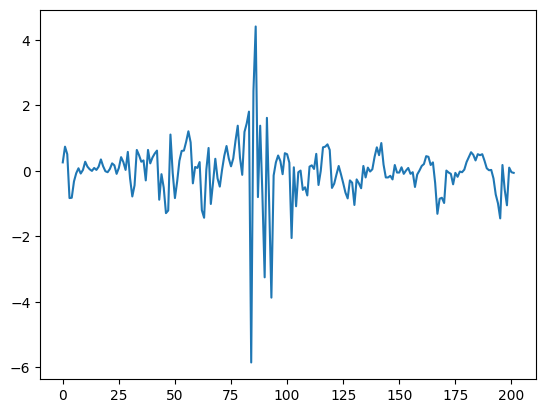

0.01881188118811881 0.34331317322284954


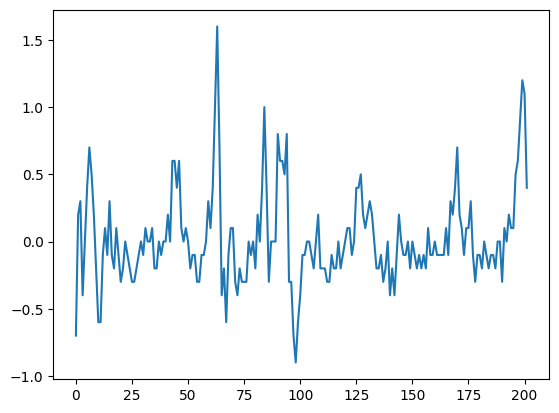

0.017623762376237667 2.7366437667277785


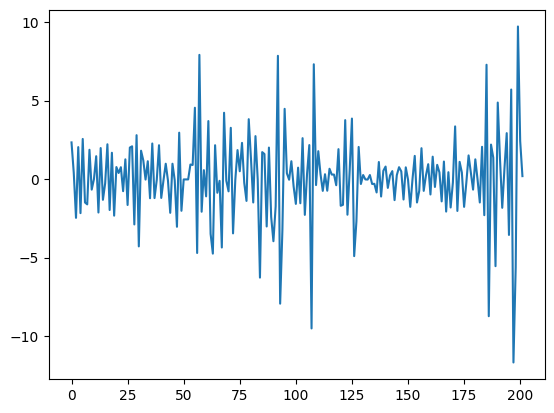

-0.017029702970297027 2.5835818426617716


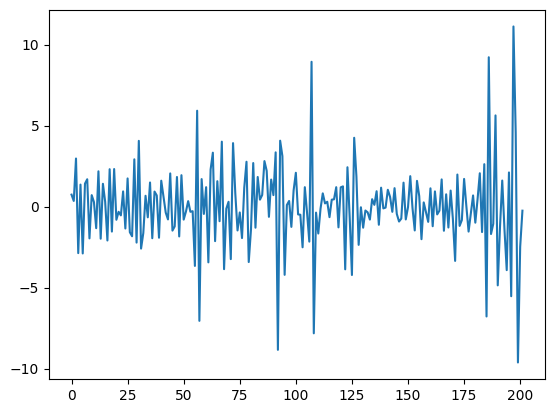

In [320]:
import statsmodels.api as sm
import pandas as pd

macro_data = sm.datasets.macrodata.load_pandas().data

# Selection of key variables (GDP, Consumption, Investment, Prices...)

cols_to_use = ['realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'infl', 'realint']
df = macro_data[cols_to_use]

# Transformation with Diff for better stationarity
df_stationary = df.diff().dropna()

Y_macro = df_stationary.values.T # (N x T)

for i in range(Y_macro.shape[0]):
     print(np.mean(Y_macro[i, :]), np.std(Y_macro[i, :]))
     plt.plot(Y_macro[i, :], label=cols_to_use[i])
     plt.show()

### We remove velocity and trend (using ewm) to have stationary signal (which is not the case ehre)

In [321]:
import pandas as pd

def prepare_signal_dynamic(Y, span=20):
    """
    Sépare le signal en Trend, Volatilité, et Cycle Normalisé.
    span : paramètre de lissage (fenêtre effective)
    """
    df = pd.DataFrame(Y.T)
    
    # Trend
    trend = df.ewm(span=span, adjust=False).mean()
    
    # Residual (Centered around 0 but with unstable variance)
    resid = df - trend
    
    # Volatility (Local standard deviation of the residual)
    # Adding a small epsilon to avoid division by zero if the signal is flat
    epsilon = 1e-8
    volatility = resid.ewm(span=span, adjust=False).std() + epsilon
    
    cycle_norm = resid / volatility
    
    return trend.values.T, volatility.values.T, cycle_norm.values.T

# span = 20 corresponds to approx. 5 years for quarterly data 
trend, volatility, cycle_norm = prepare_signal_dynamic(Y_macro, span=15)
print(trend.shape)
# Cycle : "stationnary part"
Y_statio = Y_macro - trend



(11, 202)


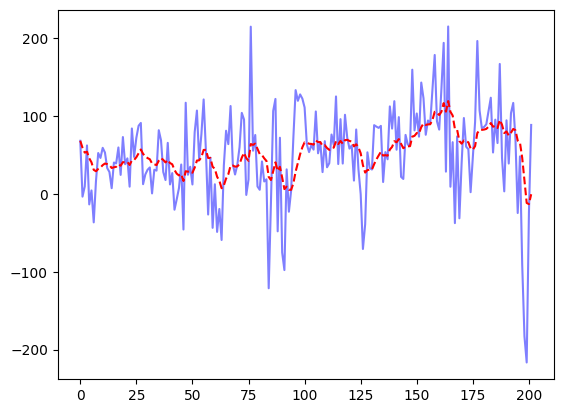

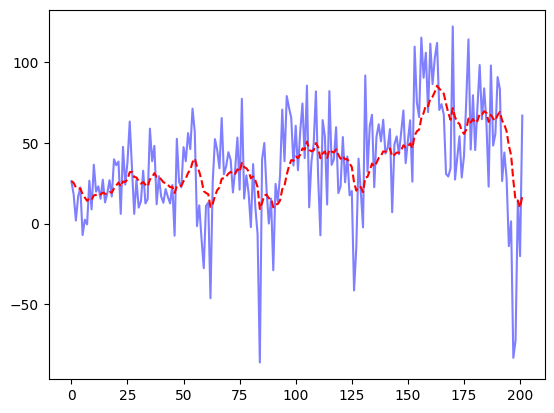

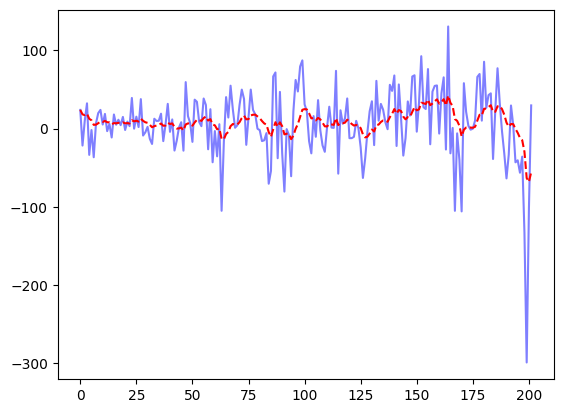

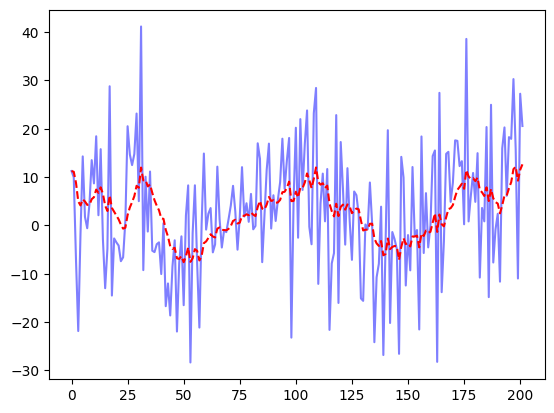

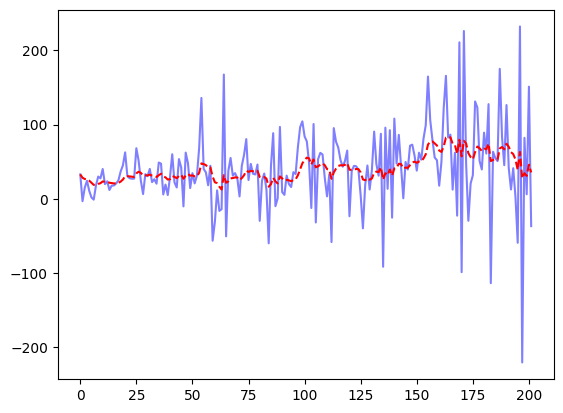

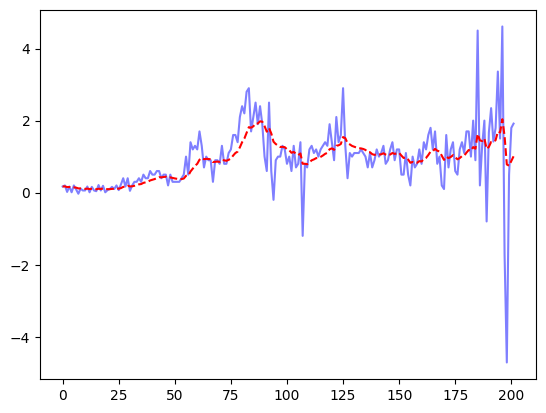

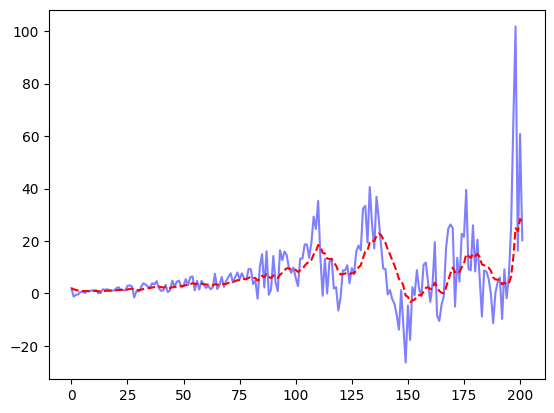

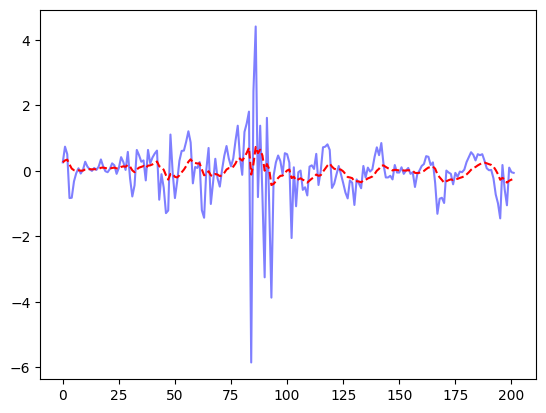

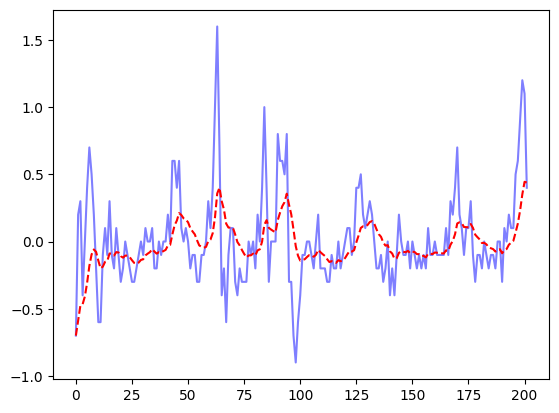

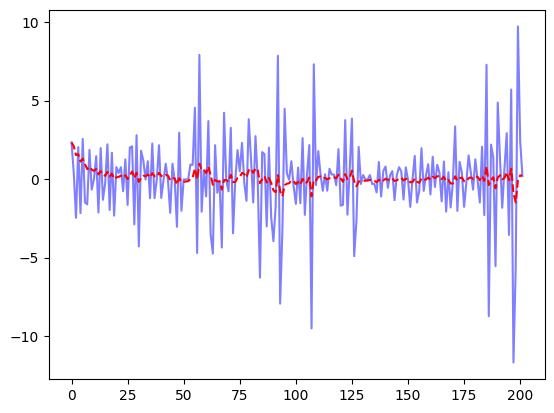

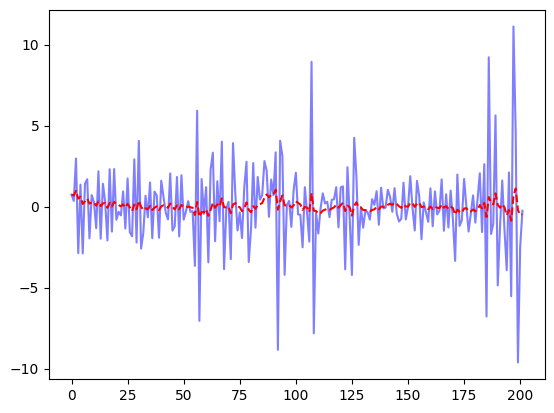

In [322]:
for i in range(Y_macro.shape[0]):
    plt.plot(Y_macro[i, :], label='Original Signal', color='blue', alpha=0.5)
    plt.plot(trend[i, :], label='Trend', color='red', linestyle='--')
    plt.show()

Check if it really looks stationnary

-2.380470345494105 50.387824359583746


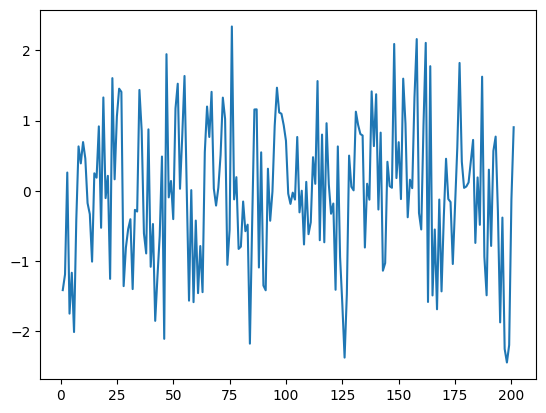

-0.3179107826820141 26.183859356821756


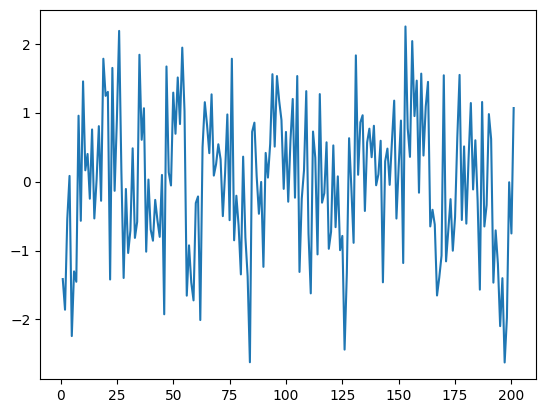

-2.765572861571008 37.870931228737454


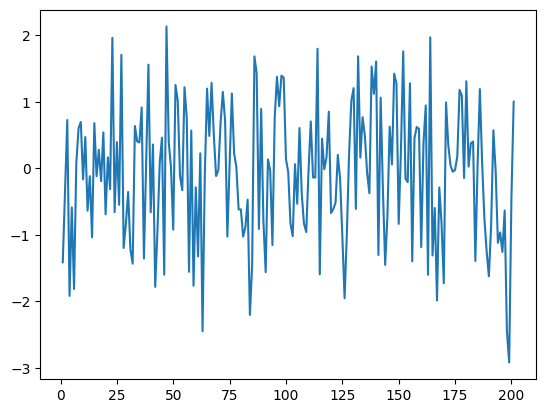

0.047701703744103686 11.074785978649722


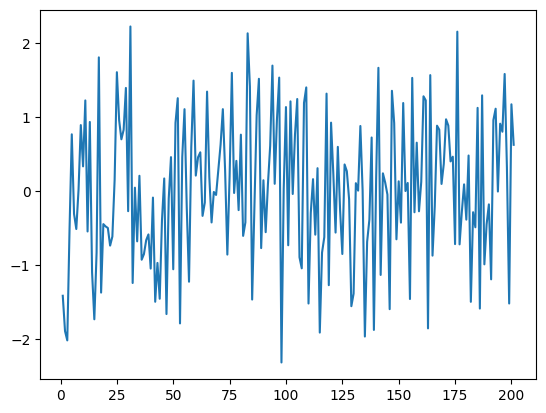

0.0943612071601394 47.54238519785026


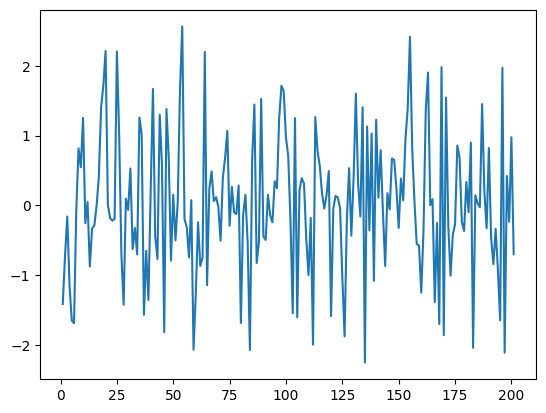

0.029049849535457594 0.7047707510935958


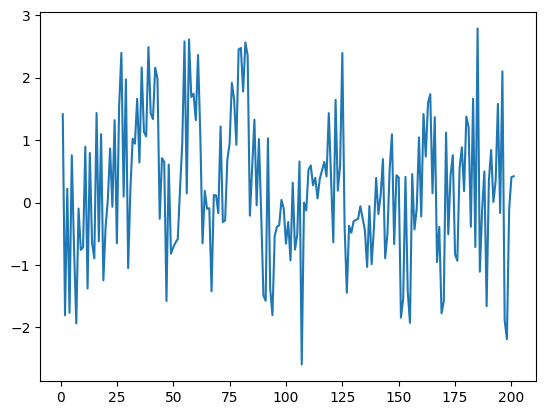

0.8803905626469395 10.299014453188448


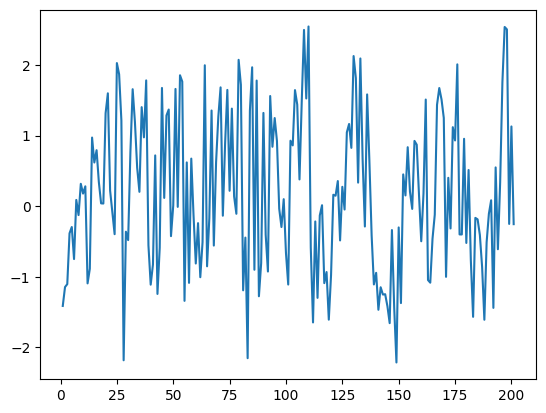

-0.01738846825291286 0.7895105158394934


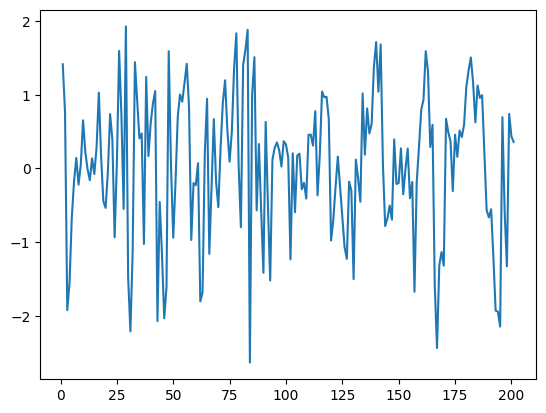

0.039463491755818314 0.29968883824763143


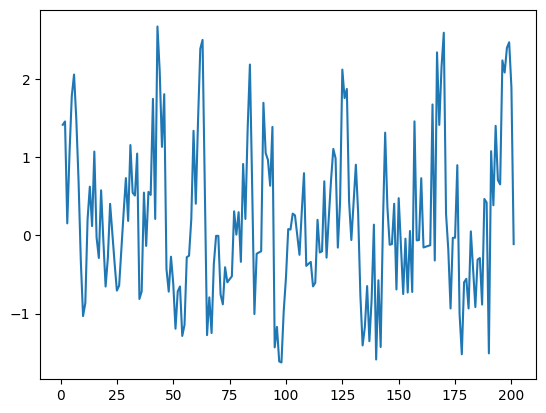

-0.07317570846516584 2.5564423416063433


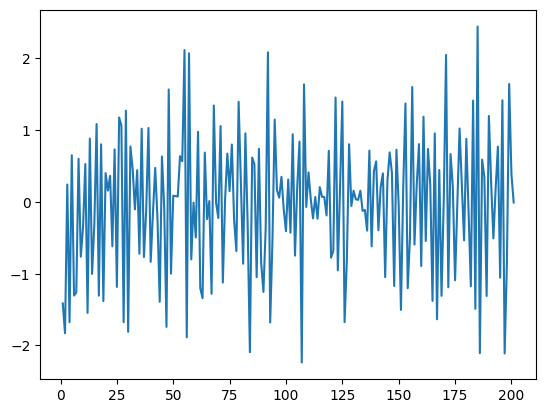

-0.04193801772744993 2.401144069541747


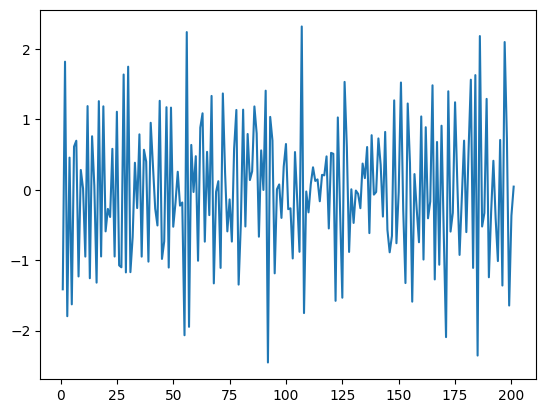

In [323]:
for i in range(Y_statio.shape[0]):
    print(np.mean(Y_statio[i, :]), np.std(Y_statio[i, :]))
    plt.plot(cycle_norm[i, :], label=cols_to_use[i] + ' (stationary)')
    plt.show()

Seems more like stationary signal here (not perfect but better)

## Forecasting on 10 iterations

In [324]:
Y_train = Y_statio[:, :170]
Y_test = Y_statio[:, 170:180]

In [325]:
N,T = Y_train.shape
P = 6

In [326]:
A_init = nuclear_norm_estimator(Y_train, T - P, P,0.1)
ranks = select_ranks(A_init, T - P, N, P)
print(ranks)
A_init = reduced_rank_regression(Y_train, T - P, P, ranks[0])
A_MLR = alternating_least_square(A_init, ranks, Y_train, T - P, P)[0]
lamb = lambda_optimal(N, P, T - P, Y_train)
A_Shorr = alternating_direction_method_of_multipliers(A_MLR, ranks, Y_train, T - P, P, [lamb/2,0.01,0.01,0.01], max_iter=100)[0]

[np.int64(3), np.int64(5), np.int64(5)]


100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


In [327]:
# Prediction with SHORR
N, T_train = Y_train.shape
H = Y_test.shape[1]  # Prediction horizon

#Initialization
current_history = Y_train[:, -P:]
Y_forecast_Shorr = np.zeros((N, H))

# recursive prediction

for h in range(H):
    pred_step = np.zeros(N)
    
    # VAR formula
    for lag in range(1, P + 1):
        pred_step += A_Shorr[:, :, lag-1] @ current_history[:, -lag]
    
    # stock prediction
    Y_forecast_Shorr[:, h] = pred_step
    
    # we remove the oldest point and append the last prediction
    pred_step_reshaped = pred_step.reshape(N, 1)
    current_history = np.hstack([current_history[:, 1:], pred_step_reshaped])

In [328]:
#Same for MLR
#Initialization
current_history = Y_train[:, -P:]
Y_forecast_MLR = np.zeros((N, H))

# recursive prediction
for h in range(H):
    pred_step = np.zeros(N)
    
    # VAR formula
    for lag in range(1, P + 1):
        pred_step += A_MLR[:, :, lag-1] @ current_history[:, -lag]
    
    # stock prediction
    Y_forecast_MLR[:, h] = pred_step
    
    # we remove the oldest point and append the last prediction
    pred_step_reshaped = pred_step.reshape(N, 1)
    current_history = np.hstack([current_history[:, 1:], pred_step_reshaped])

## Plot

MSE with shorr : 868.75339
MSE with mlr : 1065.71459


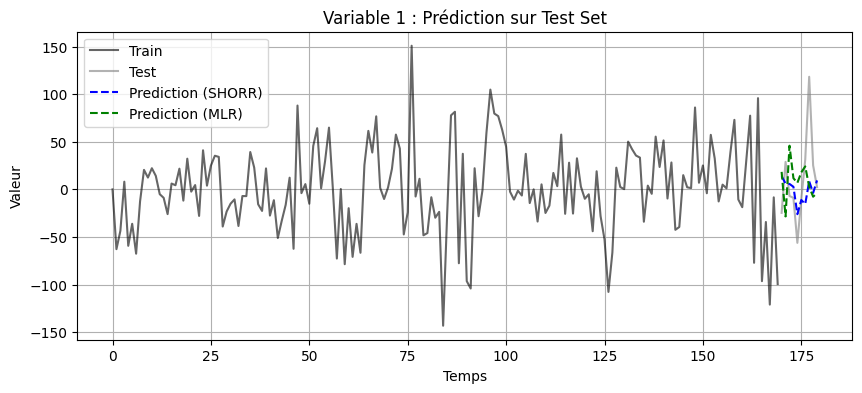

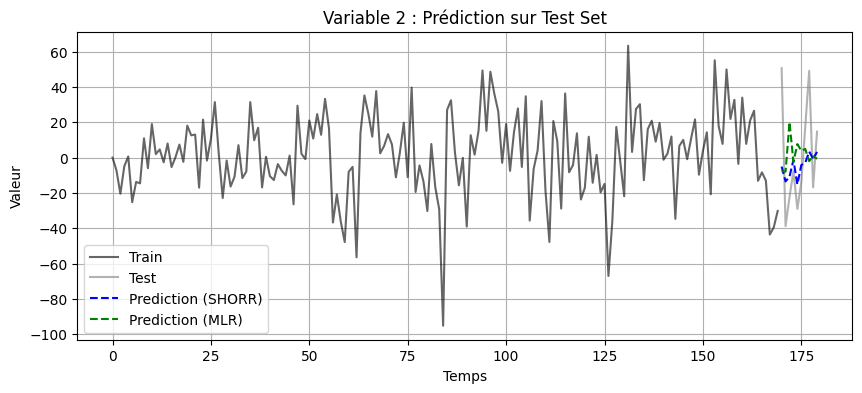

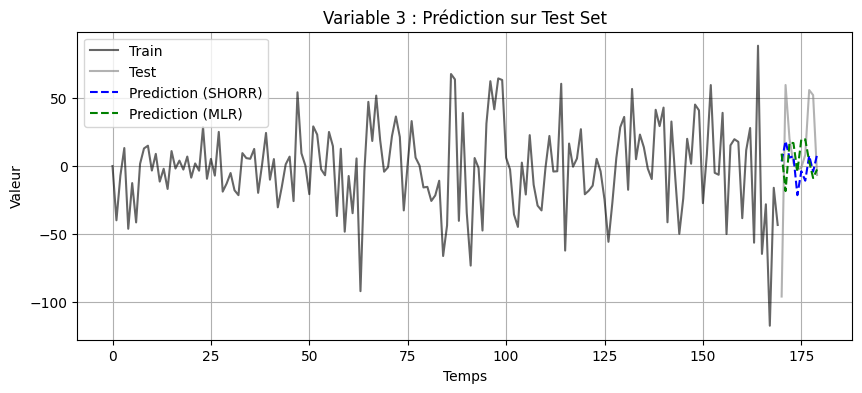

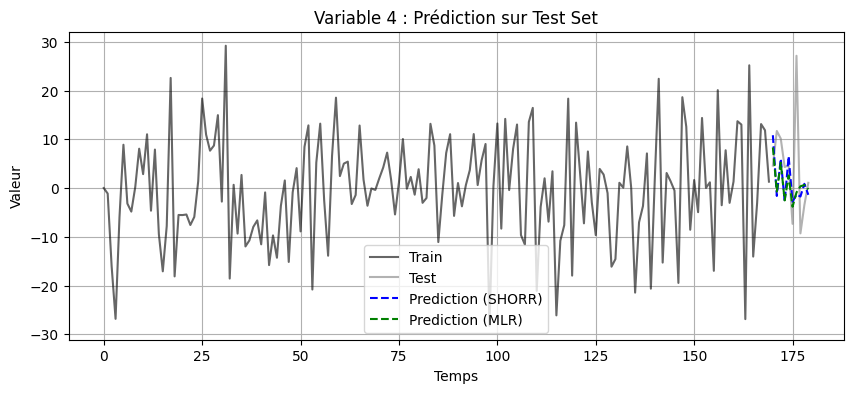

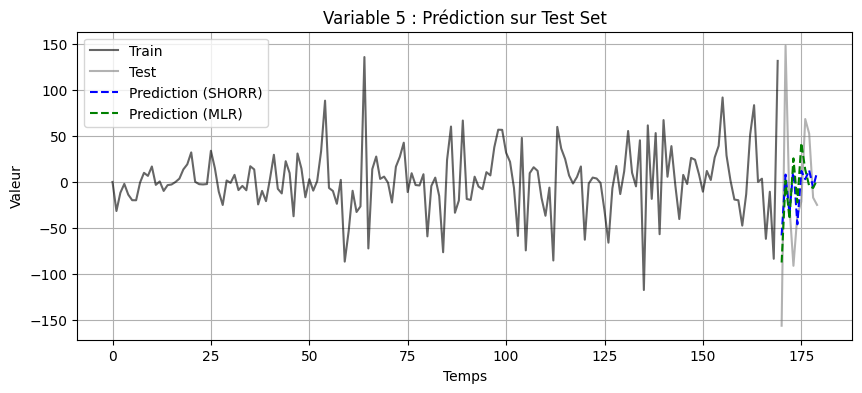

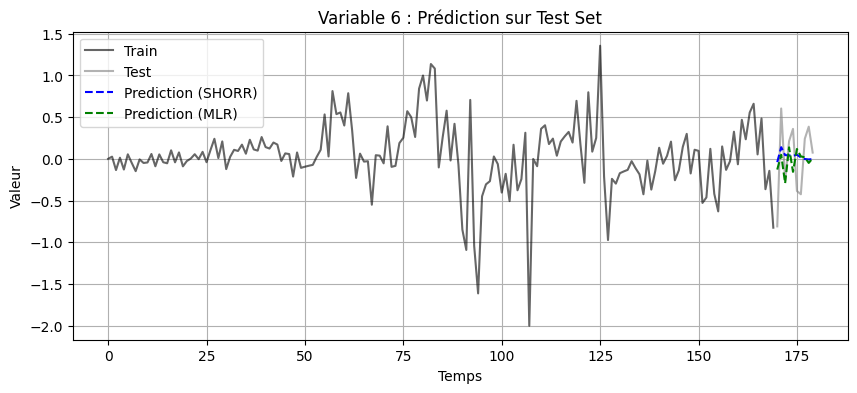

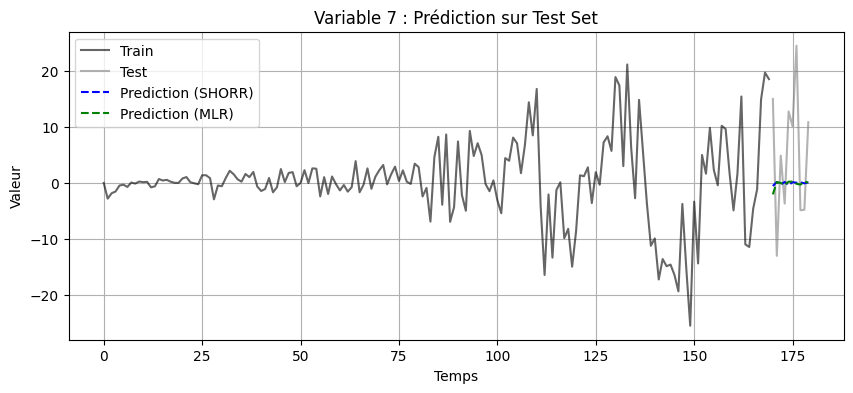

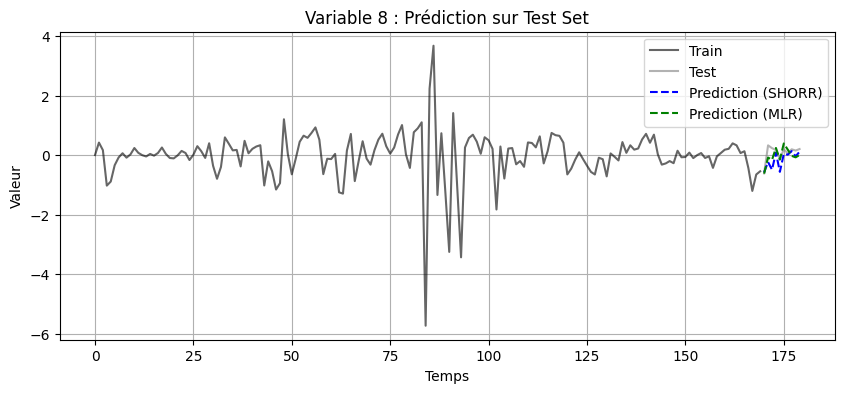

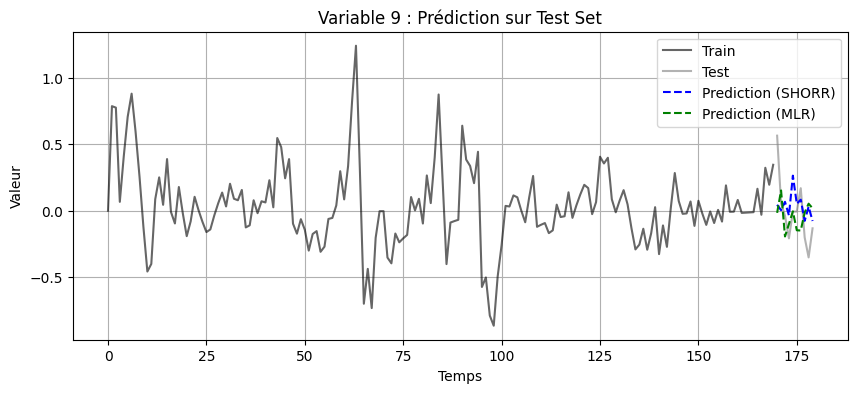

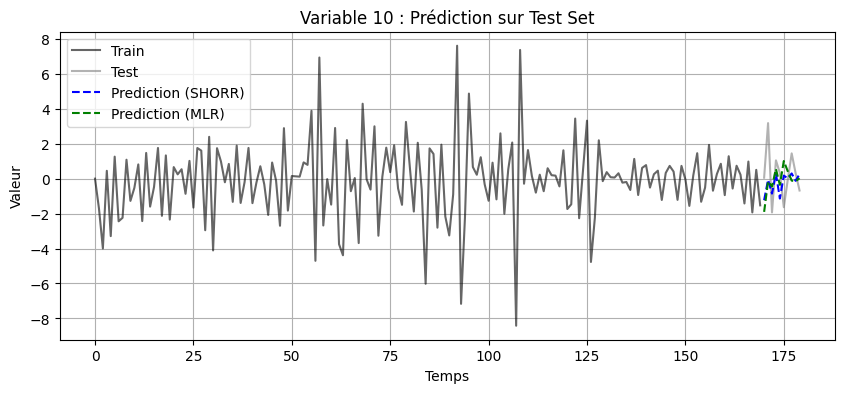

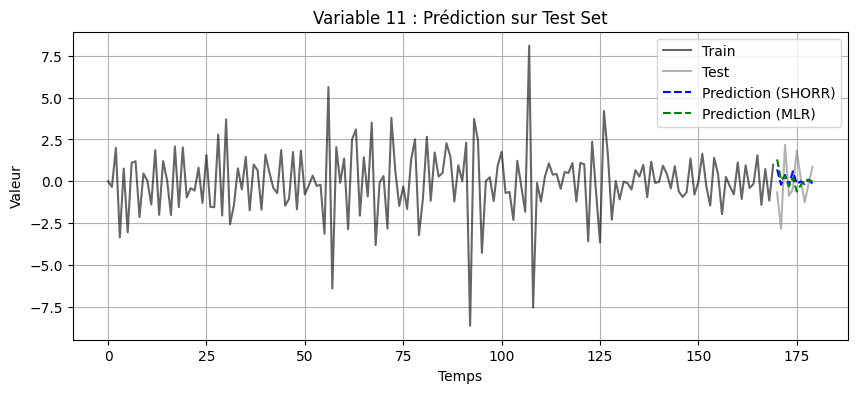

In [329]:

time_train = np.arange(T_train)
time_test = np.arange(T_train, T_train + H)

mse_test_shorr = np.mean((Y_test - Y_forecast_Shorr)**2)
print(f"MSE with shorr : {mse_test_shorr:.5f}")
mse_test_mlr = np.mean((Y_test - Y_forecast_MLR)**2)
print(f"MSE with mlr : {mse_test_mlr:.5f}")

for i in range(N):
    plt.figure(figsize=(10, 4))
    
    # real signal
    plt.plot(time_train, Y_train[i, :], label='Train', color='black', alpha=0.6)
    plt.plot(time_test, Y_test[i, :], label='Test', color='gray', alpha=0.6)
    
    # forecasted signal
    plt.plot(time_test, Y_forecast_Shorr[i, :], label='Prediction (SHORR)', color='blue', linestyle='--')
    plt.plot(time_test, Y_forecast_MLR[i, :], label='Prediction (MLR)', color='green', linestyle='--')
    
    plt.title(f'Variable {i+1} : Prédiction sur Test Set')
    plt.xlabel('Temps')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()

The prediction is pretty accurate, SHORR method is more accurate than MLR

## Forecasting at each steps (1 iteration)

In [332]:

# Reconstruction of the training signal with SHORR
Y_reconstructed_Shorr = np.zeros_like(Y_train)

Y_reconstructed_Shorr[:, :P] = Y_train[:, :P]

# Reconstruction loop
for t in range(P, T):
    prediction_t = np.zeros(N)
    for lag in range(1, P + 1):
        
        prediction_t += A_Shorr[:, :, lag-1] @ Y_train[:, t - lag]

    Y_reconstructed_Shorr[:, t] = prediction_t

In [333]:
# Reconstruction of the training signal with MLR
Y_reconstructed_MLR = np.zeros_like(Y_train)

Y_reconstructed_MLR[:, :P] = Y_train[:, :P]

# Reconstruction loop
for t in range(P, T):
    prediction_t = np.zeros(N)
    for lag in range(1, P + 1):
        
        prediction_t += A_MLR[:, :, lag-1] @ Y_train[:, t - lag]

    Y_reconstructed_MLR[:, t] = prediction_t

Mean Squared Error for Shorr(MSE) : 314.84556
Mean Squared Error for MLR(MSE) : 250.61901


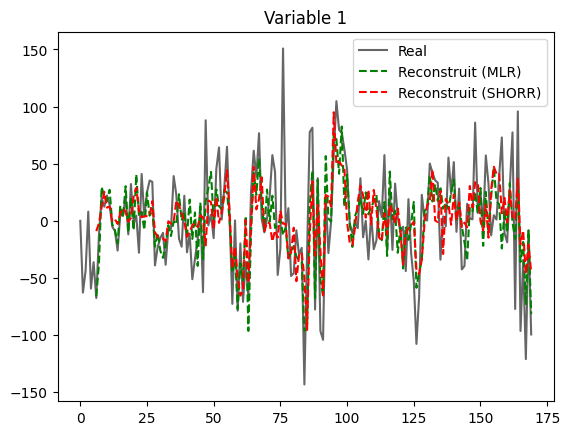

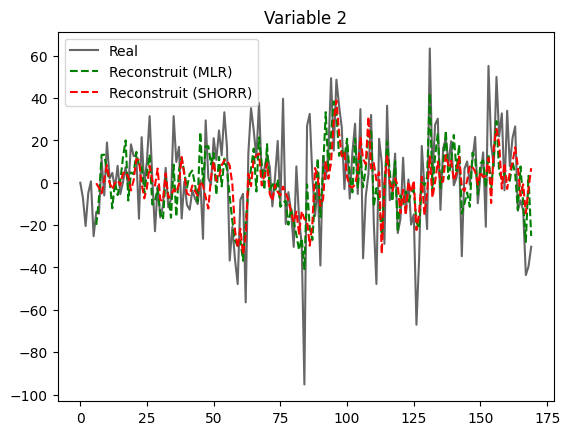

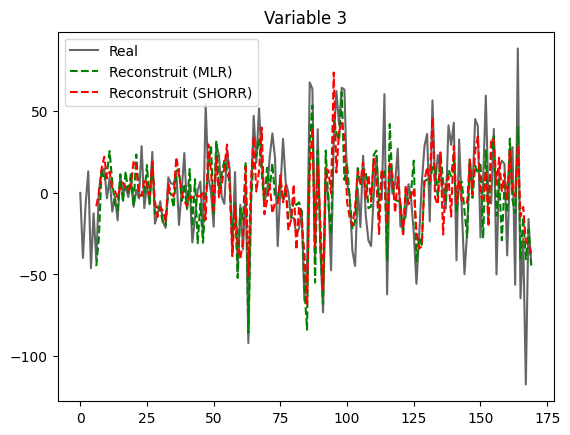

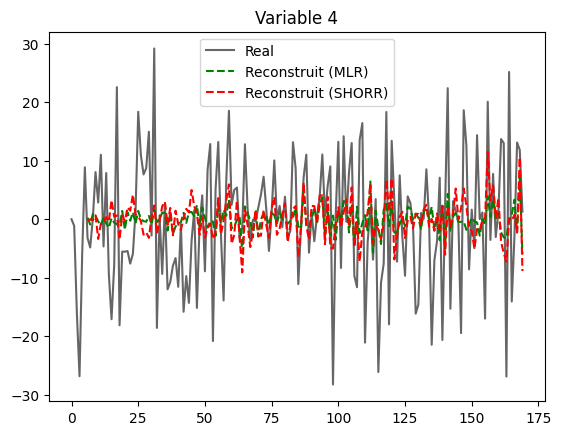

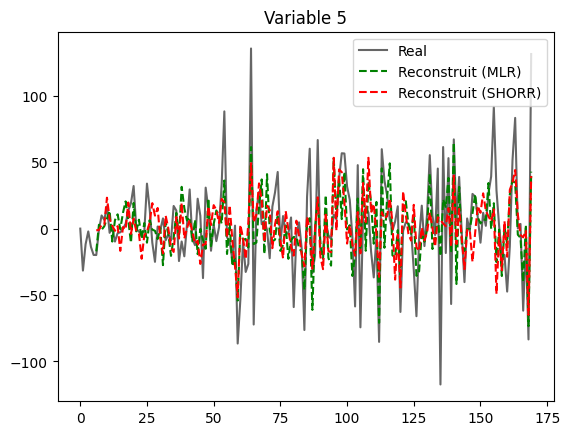

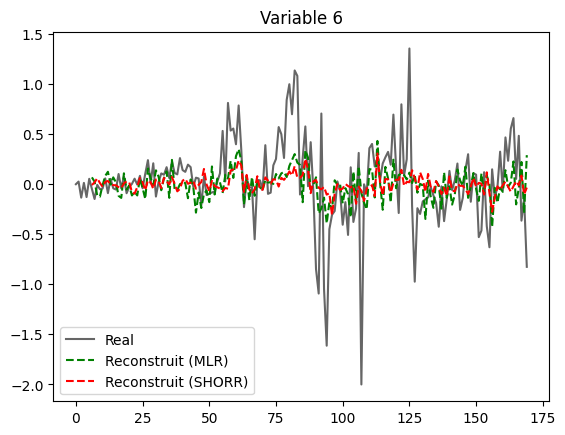

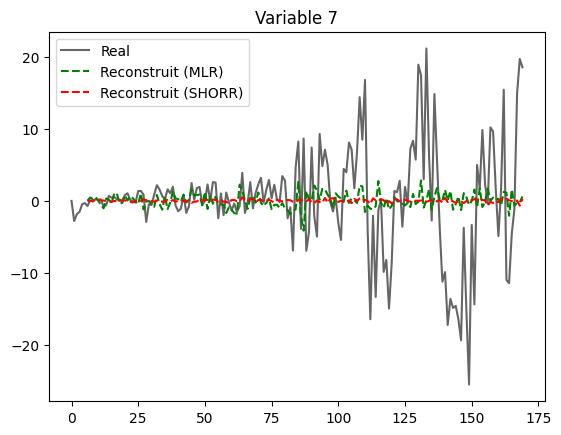

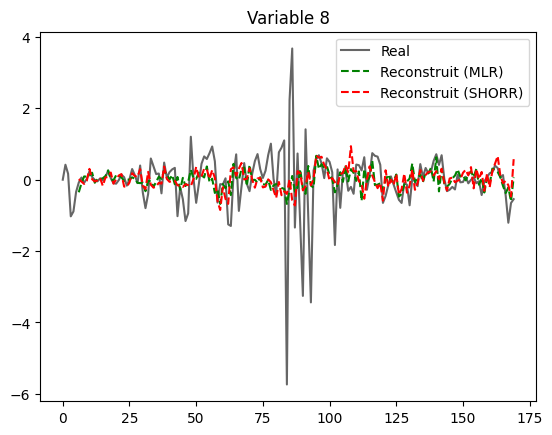

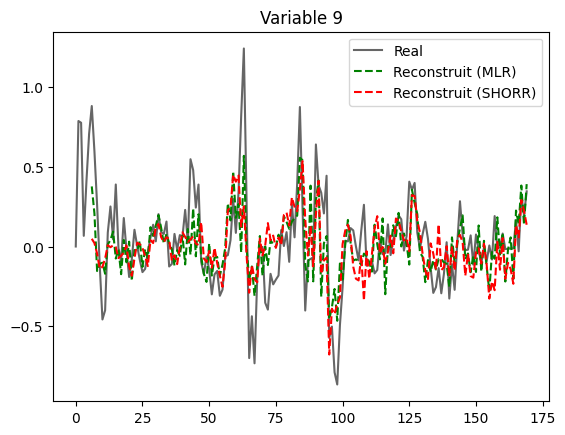

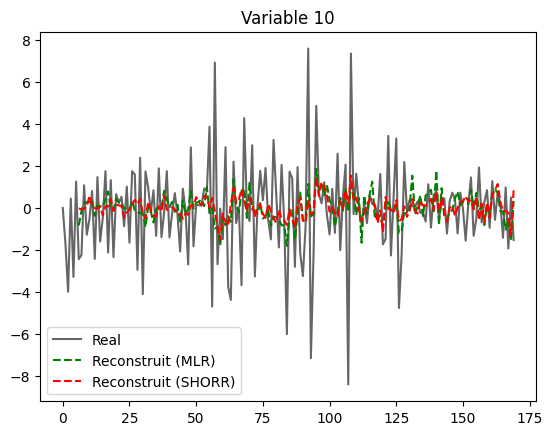

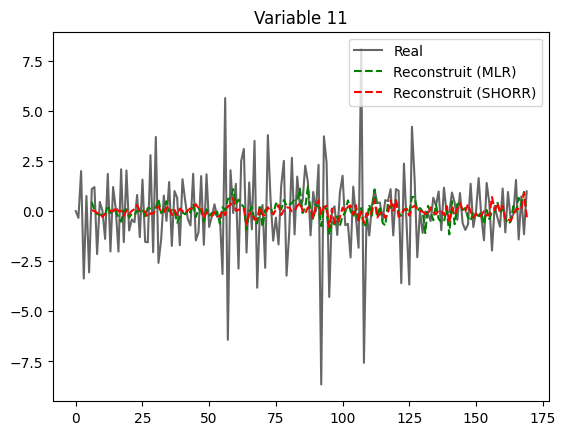

In [335]:
mse_shorr = np.mean((Y_train - Y_reconstructed_Shorr)**2)
print(f"Mean Squared Error for Shorr(MSE) : {mse_shorr:.5f}")
mse_mlr = np.mean((Y_train - Y_reconstructed_MLR)**2)
print(f"Mean Squared Error for MLR(MSE) : {mse_mlr:.5f}")

for i in range(N):

    plt.plot(Y_train[i, :], label='Real', color='black', alpha=0.6)

    plt.plot(np.arange(P, T), Y_reconstructed_MLR[i, P:], 
             label='Reconstruit (MLR)', color='green', linestyle='--')
    plt.plot(np.arange(P, T), Y_reconstructed_Shorr[i, P:], 
             label='Reconstruit (SHORR)', color='red', linestyle='--')
    plt.title(f'Variable {i+1}')
    plt.legend()
    plt.show()



On some vector it seems pretty good but for other there is still a big difference : it's because the signal are not stationary even if we tried to enforce it. Beside, MLR is better than SHORR maybe due to not that Sparse data and because of bad regularizations term choice